In [247]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import psycopg2
import pickle
from sklearn import preprocessing
import credentials
from sklearn.model_selection import learning_curve,GridSearchCV,train_test_split
import matplotlib.pylab as plt
import matplotlib.pyplot as plt1
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [248]:
# Connect to SQL Database

con=psycopg2.connect(dbname= credentials.dbname, host=credentials.host, 
port= credentials.port, user= credentials.user, password= credentials.password)


In [249]:
# Open the query that creates my dataset

fd = open(r'/Users/miqui/Documents/Miqui/Preply/Tutor Performance/Projects/Q3/TWA/TWA_Query.sql', 'r')
twa_query = fd.read()
fd.close()

In [250]:
# Store it in a variable

file = open('/Users/miqui/Documents/Miqui/Preply/Tutor Performance/Projects/Q3/TWA/TWA_Query.sql').read()

In [251]:
# Create a DataFrame based on the query:

data = pd.read_sql(file, con)

In [252]:
# Columns:

data.columns

Index(['tutor_id', 'student_id', 'subject', 'lesson_ts', 'previous_lesson',
       'duration', 'is_back_to_back_lesson', 'created_ts', 'booking_window',
       'booking_window_bin', 'lesson_id', 'tutor_lesson_order', 'first_lesson',
       'twa_flag', 'performance_segment', 'activity_segment_per_tutor_subject',
       'country_of_birth', 'date_first_approved', 'num_twa_last_30d',
       'days_since_last_seen', 'days_since_last_seen_bin', 'local_lesson_ts',
       'local_lesson_ts_date', 'local_lesson_hour', 'lesson_time_of_day',
       'local_booking_time', 'hour_offset_tutor', 'hour_offset_student',
       'hour_differences_tutor_student', 'local_booking_time_date',
       'local_booking_hour', 'booking_time_of_day', 'num_lessons_per_day',
       'one_lesson_per_day', 'app_usage', 'response_time',
       'response_time_bin'],
      dtype='object')

In [253]:
 # Some Data Cleaning:

data["twa_flag"].value_counts()

data["is_twa"] = data.apply(lambda x: 1 if x["twa_flag"] == 1 else 0, axis = 1)

data["first_lesson"] = data.apply(lambda x: 0 if x["first_lesson"] == "Not the first" else 1, axis = 1)


In [254]:
# TWA Rate of my dataset

data["twa_flag"].value_counts()[1] / data["twa_flag"].value_counts()[0] # 3.7% of TWA rate with null values

0.03710381332058267

In [255]:
# TWA Rate of the reduced dataset (after getting rid of all the nulls)

data_new = data.dropna()
data_new["twa_flag"].value_counts()[1] / data_new["twa_flag"].value_counts()[0] # 3.2% of TWA rate without null values. Would you reccommend to delete them or do something like KNN imputer. From business perspective, I'd rather not make anything up.

0.031844258780303954

In [256]:
X = data_new[['is_back_to_back_lesson', 'booking_window',
         'first_lesson',
       'days_since_last_seen',
       'local_lesson_hour',
      'num_twa_last_30d',
       'hour_differences_tutor_student',
       'local_booking_hour',
       'one_lesson_per_day', 'app_usage', 'response_time']]
Y = data_new[['is_twa']]


In [257]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model = XGBClassifier()
eval_set  = [( X_train, y_train), ( X_test, y_test)]
model.fit(X_train, y_train,eval_set=eval_set,early_stopping_rounds=10)

import pickle
file_name = "twa_20210514.pkl"
# save
pickle.dump(model, open(file_name, "wb"))

y_pred = model.predict_proba(X_test)

[22:14:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.46464	validation_1-logloss:0.46520


/Users/miqui/opt/anaconda3/envs/proyecto_final/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/miqui/opt/anaconda3/envs/proyecto_final/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.33948	validation_1-logloss:0.34060
[2]	validation_0-logloss:0.26223	validation_1-logloss:0.26381
[3]	validation_0-logloss:0.21191	validation_1-logloss:0.21397
[4]	validation_0-logloss:0.17828	validation_1-logloss:0.18078
[5]	validation_0-logloss:0.15547	validation_1-logloss:0.15834
[6]	validation_0-logloss:0.13997	validation_1-logloss:0.14317
[7]	validation_0-logloss:0.12940	validation_1-logloss:0.13306
[8]	validation_0-logloss:0.12220	validation_1-logloss:0.12626
[9]	validation_0-logloss:0.11736	validation_1-logloss:0.12184
[10]	validation_0-logloss:0.11410	validation_1-logloss:0.11900
[11]	validation_0-logloss:0.11180	validation_1-logloss:0.11729
[12]	validation_0-logloss:0.11033	validation_1-logloss:0.11618
[13]	validation_0-logloss:0.10922	validation_1-logloss:0.11552
[14]	validation_0-logloss:0.10835	validation_1-logloss:0.11501
[15]	validation_0-logloss:0.10774	validation_1-logloss:0.11474
[16]	validation_0-logloss:0.10725	validation_1-logloss:0.11455
[

In [258]:
pd.DataFrame(y_test)["is_twa"].value_counts()

0    73105
1     2334
Name: is_twa, dtype: int64

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

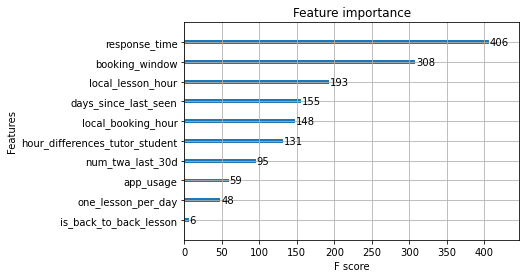

In [259]:
plot_importance(model)

In [264]:
# Predicting code:

file = open("twa_20210514.pkl",'rb')
twa_model = pickle.load(file)
file.close()

fd = open(r'/Users/miqui/Documents/Miqui/Preply/Tutor Performance/Projects/Q3/TWA/TWA_Query_tutors.sql', 'r')
twa_query = fd.read()
fd.close()

data_predict = pd.read_sql(twa_query, con)

data_predict['twa_prob'] = twa_model.predict_proba(data_predict[twa_model.get_booster().feature_names])[:,1]
data_predict['is_bad_twa'] = 1*(data_predict['twa_prob']>=0.25) # Buscar la mínima probabilidad e un tutor que ha hecho TWA.
data_predict_final = data_predict[['tutor_id', 'twa_prob', 'is_bad_twa', 'num_twa_last_30d']]

# Binomial

In [192]:
data_predict_final[data_predict_final['is_bad_twa']==1]['tutor_id'].to_csv("tutors_predicted.csv")

In [263]:
np.mean(data_predict_final[data_predict_final['num_twa_last_30d']>=1]['twa_prob'])

0.25098180770874023

In [265]:
data_predict[data_predict_final['is_bad_twa']==1].head()

,tutor_id,subject,date_to_join,num_twa_last_30d,is_back_to_back_lesson,booking_window,first_lesson,days_since_last_seen,local_lesson_hour,hour_differences_tutor_student,local_booking_hour,one_lesson_per_day,app_usage,response_time,twa_prob,is_bad_twa
30,40841,english,2021-06-08,0,0.0,58.0,0.25,17.0,12.75,2.25,14.75,1.0,0.0,13.225,0.506872,1
35,308436,english,2021-06-08,0,0.0,29.0,0.00,375.0,12.00,7.00,7.00,1.0,0.0,0.000,0.435729,1
54,1590636,math,2021-06-08,0,0.0,138.0,1.00,11.0,14.00,3.00,20.00,1.0,0.0,0.000,0.539303,1
108,241729,english,2021-06-09,0,0.0,165.5,0.50,160.0,11.50,0.00,14.00,1.0,0.0,0.000,0.776900,1
168,1231179,english,2021-06-09,0,0.0,40.0,1.00,6.0,16.00,2.00,0.00,1.0,0.0,0.000,0.655906,1


In [268]:
data_predict_final["is_bad_twa"].value_counts()

0    32316
1     2555
Name: is_bad_twa, dtype: int64